In [2]:
%cd ..

/Users/michaelbarrientos/Desktop/ev_battery_health_forecast


In [45]:
#Import and laod dependencies
import numpy as np 
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from src.cleaning import load_and_clean

### Feature Scaling

In [46]:
#Utility Functions
def create_sequences(df, feature_cols, target_col, seq_len=24):
    #    Turn a DataFrame into sliding windows X (seq_len × features) and y targets.
    features = df[feature_cols].values
    targets = df[target_col].values
    x, y = [], []
    for i in range(len(df)-seq_len):
        x.append(features[i: i + seq_len])
        y.append(targets[i + seq_len])
    return np.array(x), np.array(y)

def make_loaders(x, y, split=0.8, batch_size=32):
    #    Split into train/test and wrap in DataLoaders.
    cutoff = int(len(x) * split)
    
    x_train, x_test = x[:cutoff], x[cutoff:]
    y_train, y_test = y[:cutoff], y[cutoff:]

    
    train_ds = TensorDataset(
        torch.from_numpy(x_train).float(), 
        torch.from_numpy(y_train).float()
    )
    test_ds =TensorDataset(
        torch.from_numpy(x_test).float(), 
        torch.from_numpy(y_test).float()) 
    
    return(
        DataLoader(train_ds, batch_size=batch_size, shuffle=True), 
        DataLoader(test_ds, batch_size=batch_size)
    )

In [54]:
#1. Load and clean
df = load_and_clean('data/raw/ev_metrics.csv')

#2. Feature scaling
from sklearn.preprocessing import StandardScaler
feature_cols = ['Capacity','ambient_temperature']
scaler_X = StandardScaler()
df[feature_cols] = scaler_X.fit_transform(df[feature_cols].values)
scaler_y = StandardScaler()
df['SOH_norm'] = scaler_y.fit_transform(df[['SOH']].values)

#3. Build sequences on the normalized target
X, y = create_sequences(df, feature_cols, 'SOH_norm', seq_len=24)

#4. Wrap in loaders
train_loader, test_loader = make_loaders(X, y, split=0.8, batch_size=32)
print("Train batches:", len(train_loader), "Test batches:", len(test_loader))


Train batches: 69 Test batches: 69


### Model Definition

We define an LSTM based regressor, 'SoHForecaster', which takes in our sequence of features and outputs a single SOH prediction for the next time step.

In [61]:
class SoH_Forecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        #1. input_dim: number of features per time step
        #2. hidden_dim: size of the LSTM's hidden state
        #3. num_layers: number of LSTM layer
        
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, x):
        #x: [batch_size, seq_len, imput_dim]
        
        #out: [batch_size, seq_len, hidden_dim]
        #take hidden state at final time step
        # -> [batch_size]
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.mlp(last).squeeze()

### Training Loop

We define a helper 'train_model()' that takes our model and training loader, runs for N epochs, and returns the history of MSE loss for plotting.

In [62]:
def train_model(model, loader, epochs=20, lr=1e-3):
    #1.  Train 'model' on data from 'loader' for 'N' epochs.
    #2. Return a list of average training losses per epoch.
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    history = []
    
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for xb, yb in loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        history.append(avg_loss)
        print(f"Epoch {epoch}/{epoch} - Loss: {avg_loss:.4f}")
    return history

### Run Training & Plot Loss Curve

Instantiate the model, call 'train_model()', and visualize how the training loss decreases over epochs.

Epoch 1/1 - Loss: 0.6276
Epoch 2/2 - Loss: 0.2223
Epoch 3/3 - Loss: 0.1991
Epoch 4/4 - Loss: 0.1914
Epoch 5/5 - Loss: 0.1896
Epoch 6/6 - Loss: 0.1865
Epoch 7/7 - Loss: 0.1810
Epoch 8/8 - Loss: 0.1775
Epoch 9/9 - Loss: 0.1762
Epoch 10/10 - Loss: 0.1758
Epoch 11/11 - Loss: 0.1784
Epoch 12/12 - Loss: 0.1730
Epoch 13/13 - Loss: 0.1742
Epoch 14/14 - Loss: 0.1707
Epoch 15/15 - Loss: 0.1733
Epoch 16/16 - Loss: 0.1679
Epoch 17/17 - Loss: 0.1682
Epoch 18/18 - Loss: 0.1708
Epoch 19/19 - Loss: 0.1684
Epoch 20/20 - Loss: 0.1678


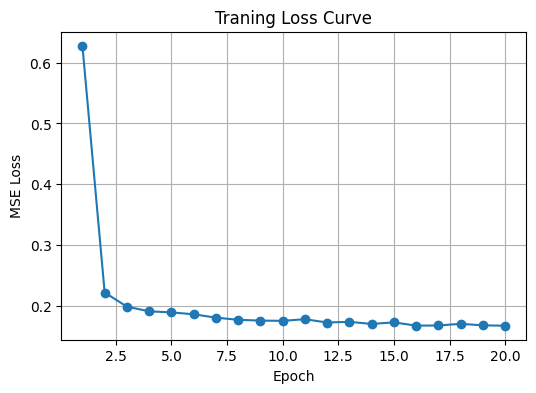

In [63]:
#Instatntiate the model
model = SoH_Forecaster(input_dim=len(feature_cols))

#Train and collect loss history
loss_history = train_model(model, train_loader, epochs=20, lr=1e-3)

#Plot training loss
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Traning Loss Curve')
plt.grid(True)
plt.show()

### Test Set Evaluation and Model Saving

We use the trained model to predict on the test set, compare against actual SOH values, and then save the model weights for future inference or deployment.

First 10 actuals: [47.95450287 47.01851972 46.58401172 46.51588067 45.98171028 46.10889211
 45.73016691 44.99899206 44.933248   47.77735986]
First 10 preds:   [46.06049745 46.95659452 47.10525232 46.92729498 46.68253181 46.24934529
 45.92390659 45.54618903 45.0106289  44.62328126]
Preds min/max: -0.15519294526105654 / 75.61522877515397


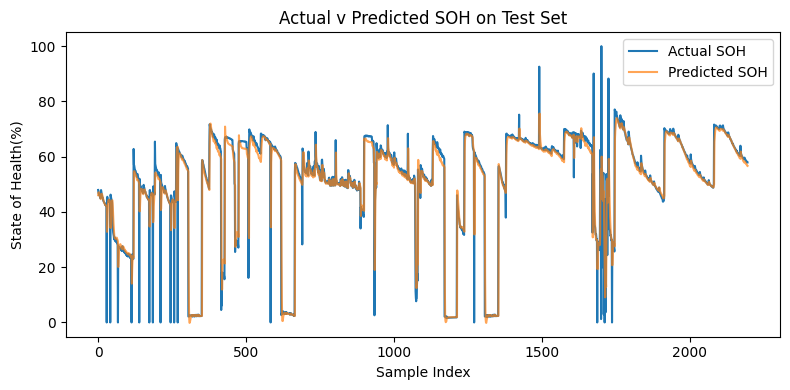

Test RMSE:  339.089 SOH points
Models weights saved to models/soh_forecaster.pt


In [64]:
#1. switch to eval mode
model.eval()

#2. Collect predictions and ground truth
preds_norm, actuals_norm = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb)
        preds_norm.extend(model(xb).tolist())
        actuals_norm.extend(yb.tolist())
        
#Denormalization
preds_norm_arr   = np.array(preds_norm).reshape(-1, 1)
actuals_norm_arr = np.array(actuals_norm).reshape(-1, 1)

preds   = scaler_y.inverse_transform(preds_norm_arr).flatten()
actuals = scaler_y.inverse_transform(actuals_norm_arr).flatten()

# After model.eval() and looping through test_loader:
print("First 10 actuals:", actuals[:10])
print("First 10 preds:  ", preds[:10])
print("Preds min/max:", min(preds), "/", max(preds))

        
#3. Plot actual v Predicted SOH
plt.figure(figsize=(8,4))
plt.plot(actuals, label='Actual SOH')
plt.plot(preds, label='Predicted SOH', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('State of Health(%)')
plt.title('Actual v Predicted SOH on Test Set')
plt.legend()
plt.tight_layout()
plt.show()

#4. Compute numeric metric
mse = sum((p - a) ** 2 for p, a in zip(preds, actuals))
rmse = math.sqrt(mse)
print(f"Test RMSE: {rmse: .3f} SOH points")

#5. Save model weights
torch.save(model.state_dict(), 'models/soh_forecaster.pt')
print("Models weights saved to models/soh_forecaster.pt")